In [10]:
from datasets import load_dataset
import pandas as pd

# https://huggingface.co/datasets/bghira/free-to-use-pixelart
ds = load_dataset("bghira/free-to-use-pixelart")

In [11]:
train = ds['train']
df = pd.DataFrame(train)
df.head(3)

,subset,sequence,subset-sequence-element,title,description,views,filename,pixel_size,has_watermark,image_hash,image_url,full_image_url,likes_count,comments_count,width,height,date_created,content_warning,warning,liked
0,highlighted,1,highlighted.1.1,Highlander,,36,sr2e3cecf2e99aws3-1 Highlander.png,6,False,sr2e3cecf2e99aws3,https://art.pixilart.com/thumb/sr2e3cecf2e99aw...,https://art.pixilart.com/sr2e3cecf2e99aws3.png,9,0,200,250,05/25/2024,None,False,False
1,highlighted,1,highlighted.1.2,Dungeon Key,#challenge,166,sr26fa2adb2a6aws3-2 Dungeon Key.png,14,False,sr26fa2adb2a6aws3,https://art.pixilart.com/thumb/sr26fa2adb2a6aw...,https://art.pixilart.com/sr26fa2adb2a6aws3.gif,49,2,54,100,05/25/2024,None,False,False
2,highlighted,1,highlighted.1.3,Mecha1old,Old mecha i did back in 2022,117,sr20b7ff421b0aws3-3 Mecha1old.png,11,False,sr20b7ff421b0aws3,https://art.pixilart.com/thumb/sr20b7ff421b0aw...,https://art.pixilart.com/sr20b7ff421b0aws3.gif,39,0,128,128,05/25/2024,None,False,False


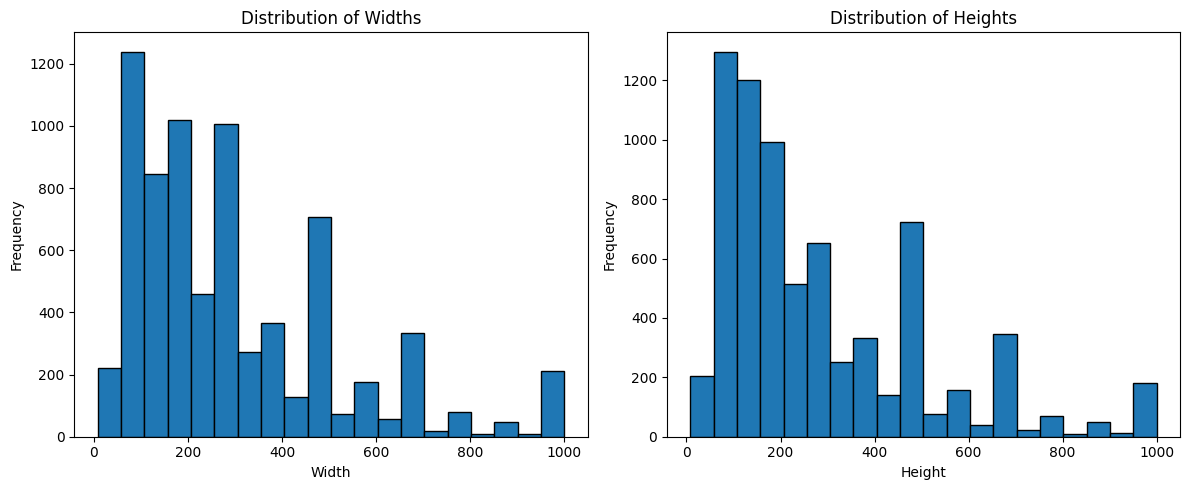

In [12]:
import matplotlib.pyplot as plt

# Assuming 'width' and 'height' are columns in your DataFrame 'df'
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['width'], bins=20, edgecolor='black')  # Adjust bins as needed
plt.title('Distribution of Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['height'], bins=20, edgecolor='black')  # Adjust bins as needed
plt.title('Distribution of Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

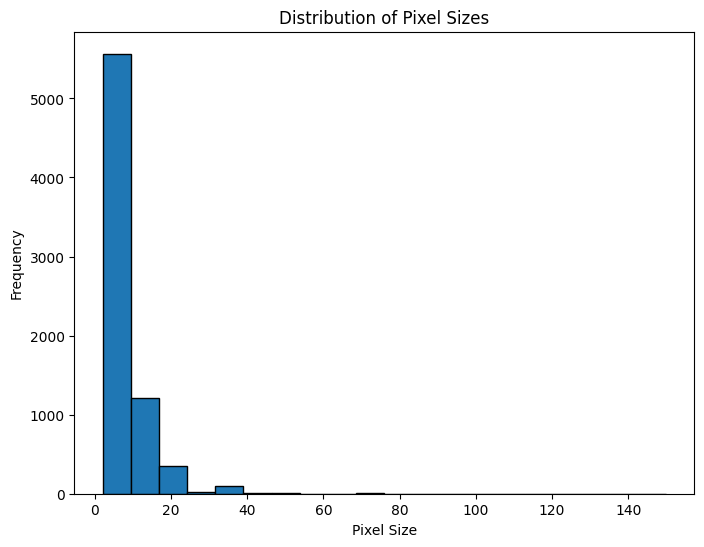

In [4]:
plt.figure(figsize=(8, 6))
plt.hist(df['pixel_size'], bins=20, edgecolor='black')  # Adjust bins as needed
plt.title('Distribution of Pixel Sizes')
plt.xlabel('Pixel Size')
plt.ylabel('Frequency')
plt.show()

In [5]:
import requests
from PIL import Image
from io import BytesIO

def get_image_from_url(image_url):
    try:
        response = requests.get(image_url)
        response.raise_for_status()  # Raise an exception for bad status codes
        image = Image.open(BytesIO(response.content))
        return image
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
        return None
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

def scale_image(image: Image.Image, factor: float) -> Image.Image | None:
    """Scales a PIL Image down by a factor and returns a new PIL Image.

    Args:
        image: The PIL Image to scale.
        factor: The scaling factor (e.g., 0.5 for half the size).

    Returns:
        A new PIL Image scaled down by the factor, or None if an error occurs.
    """
    try:
        width, height = image.size
        new_width = int(width * factor)
        new_height = int(height * factor)
        scaled_image = image.resize((new_width, new_height), resample=Image.Resampling.NEAREST)
        return scaled_image
    except Exception as e:
        print(f"Error scaling image: {e}")
        return None

In [6]:
SAMPLE_SIZE = 100
df_sample = df.sample(SAMPLE_SIZE)

In [7]:
from tqdm import tqdm

n_data_consistency_good = 0
n_data_consistency_bad = 0
for i, item in tqdm(df_sample.iterrows()):
    img_url = item["full_image_url"]
    img = get_image_from_url(img_url)
    scaled_width = item["width"] * item["pixel_size"]
    scaled_height = item["height"] * item["pixel_size"]
    if img.size[0] == scaled_width and img.size[1] == scaled_height:
        n_data_consistency_good += 1
    else:
        n_data_consistency_bad += 1
print("Data consistency check:")
print("n_data_consistency_good: ", n_data_consistency_good)
print("n_data_consistency_bad: ", n_data_consistency_bad)


100it [00:44,  2.23it/s]

Data consistency check:
n_data_consistency_good:  97
n_data_consistency_bad:  3


In [8]:
n_scalability_good = 0
n_scalability_bad = 0
for i, item in tqdm(df_sample.iterrows()):
    img = get_image_from_url(item["full_image_url"])
    # scale image down by pixel size
    scale_factor = item['pixel_size']
    scaled_img = scale_image(img, 1 / scale_factor)
    # scale back up by pixel size
    scaled_back_up_img = scale_image(scaled_img, scale_factor)
    # compare raw with rescaled back up for exact match, use checksums
    if img.tobytes() == scaled_back_up_img.tobytes():
        n_scalability_good += 1
    else:
        n_scalability_bad += 1
print("Image scaling check:")
print("n_scalability_good: ", n_scalability_good)
print("n_scalability_bad: ", n_scalability_bad)

100it [00:09, 10.37it/s]

Image scaling check:
n_scalability_good:  94
n_scalability_bad:  6


In [9]:
import ipywidgets as widgets
from IPython.display import display

def analyze_image(index):
    # get image
    img_url = df['full_image_url'][index]
    img = get_image_from_url(img_url)
    # display(img)

    # scale image down by pixel size
    scale_factor = df['pixel_size'][index]
    scaled_img = scale_image(img, 1 / scale_factor)
    display(scaled_img)

    # scale back up by pixel size
    scaled_back_up_img = scale_image(scaled_img, scale_factor)
    # display(scaled_back_up_img)

    # compare raw with rescaled back up for exact match, use checksums
    if img.tobytes() == scaled_back_up_img.tobytes():
        print("Exact match")
    else:
        print("No match")

image_slider = widgets.IntSlider(
    min=0,
    # max=len(df) - 1,
    max=100,
    step=1,
    description='Image Index:',
    value=0
)

widgets.interactive(analyze_image, index=image_slider)


interactive(children=(IntSlider(value=0, description='Image Index:'), Output()), _dom_classes=('widget-interac…